### 良好的算法架构可以为后期科研工作提供很大的便利。在此我提出两种节点规划算法的架构，希望能够为后续的研究工作提供一些参考。    

读取xml文件中的变量

In [2]:
import os
import xml.etree.ElementTree as ET

# 获取当前文件夹路径
current_folder = os.getcwd()

# XML文件路径
xml_file = os.path.join(current_folder, 'variables.xml')

# 解析XML文件
tree = ET.parse(xml_file)
root = tree.getroot()

# 遍历所有variable节点
variables = {}
for variable in root.findall('.//variable'):
    name = variable.get('name')
    value = variable.text
    variables[name] = value

# 打印所有变量及其值
for name, value in variables.items():
    print(f'{name}: {value}')

var1: value1
var2: value2
var3: value3


```text
在大小为a*b的地图中随机生成n个节点,节点生成时不需要考虑参数d。
将整个地图划分为边长为d的矩形区域，在GUI界面中绘制矩形图以及节点，找到并使用其他颜色绘制含有节点的区域。
路径规划算法应以矩形为单位，旅行商从(0,0)出发，到(a,b)结束。每次行动从当前矩形中心前往相邻的八个矩形中心之一，每个节点可以被访问多次，使路径最短。若节点之间无法相互连接，可以启用未被占据的节点。
将算法模块化为一个函数，输入参数包括：(地图长宽a、b，节点个数n，矩形边长d)，以及节点列表，输出路径列表。
在得到路径列表后，生成路径并绘制。
```

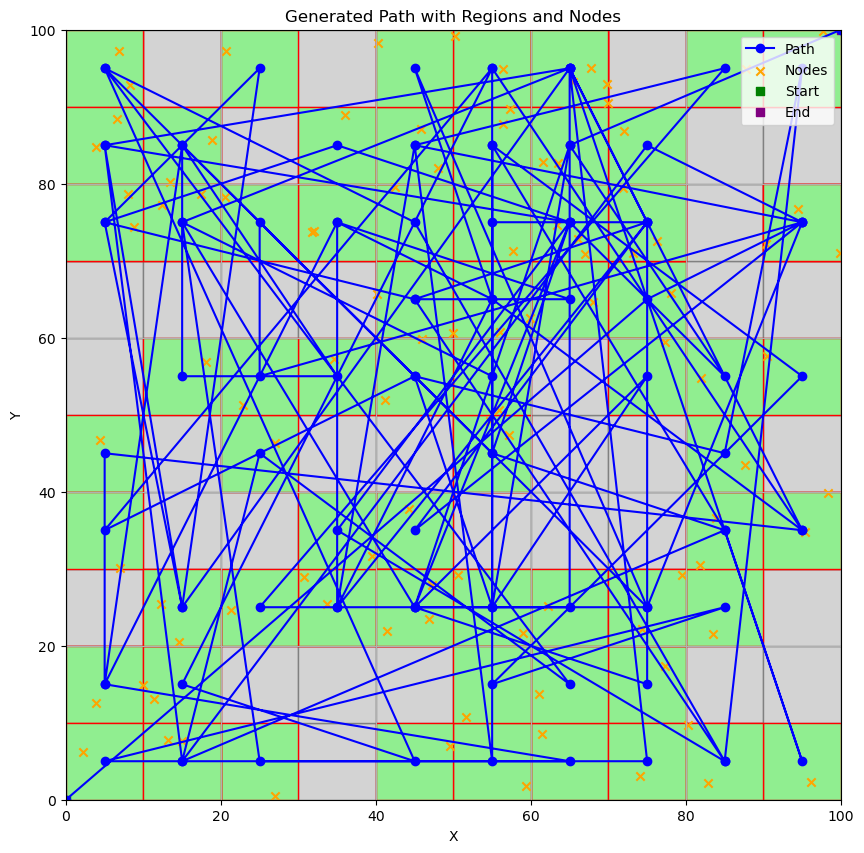

Coordinates: [(0, 0), (75.0, 65.0), (95.0, 75.0), (45.0, 35.0), (75.0, 75.0), (65.0, 95.0), (5.0, 85.0), (65.0, 75.0), (45.0, 25.0), (75.0, 15.0), (75.0, 75.0), (45.0, 65.0), (65.0, 65.0), (35.0, 75.0), (5.0, 15.0), (65.0, 5.0), (25.0, 5.0), (15.0, 75.0), (45.0, 25.0), (75.0, 55.0), (55.0, 25.0), (55.0, 75.0), (75.0, 75.0), (35.0, 25.0), (35.0, 75.0), (55.0, 65.0), (35.0, 25.0), (45.0, 85.0), (95.0, 75.0), (75.0, 85.0), (15.0, 5.0), (25.0, 45.0), (65.0, 15.0), (5.0, 95.0), (45.0, 75.0), (85.0, 5.0), (45.0, 65.0), (5.0, 75.0), (35.0, 85.0), (65.0, 75.0), (55.0, 45.0), (55.0, 85.0), (55.0, 5.0), (45.0, 85.0), (85.0, 95.0), (25.0, 25.0), (65.0, 25.0), (65.0, 95.0), (95.0, 5.0), (85.0, 35.0), (55.0, 45.0), (15.0, 85.0), (15.0, 55.0), (35.0, 55.0), (15.0, 85.0), (5.0, 15.0), (5.0, 45.0), (95.0, 35.0), (55.0, 95.0), (5.0, 35.0), (45.0, 55.0), (55.0, 25.0), (65.0, 85.0), (45.0, 25.0), (75.0, 25.0), (5.0, 95.0), (45.0, 5.0), (15.0, 15.0), (55.0, 95.0), (55.0, 55.0), (15.0, 75.0), (65.0, 95.0),

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import distance_matrix
from heapq import heappop, heappush

def generate_nodes(a, b, n):
    """在地图内随机生成n个节点"""
    return [(np.random.uniform(0, a), np.random.uniform(0, b)) for _ in range(n)]

def divide_map_into_regions(a, b, d):
    """将地图划分为边长为d的矩形区域"""
    regions = []
    x_splits = int(np.ceil(a / d))
    y_splits = int(np.ceil(b / d))
    for i in range(x_splits):
        for j in range(y_splits):
            x1, y1 = i * d, j * d
            x2, y2 = min(x1 + d, a), min(y1 + d, b)
            region_center = ((x1 + x2) / 2, (y1 + y2) / 2)
            regions.append(((x1, y1, x2, y2), region_center))
    return regions

def find_regions_with_nodes(regions, nodes):
    """找到包含节点的区域并标记"""
    regions_with_nodes = []
    for node in nodes:
        for region, center in regions:
            x1, y1, x2, y2 = region
            if x1 <= node[0] < x2 and y1 <= node[1] < y2:
                regions_with_nodes.append((region, center))
                break
    return regions_with_nodes

def create_adjacency_matrix(region_centers, d):
    """创建相邻矩形的邻接矩阵"""
    n = len(region_centers)
    adj_matrix = np.zeros((n, n))
    distances = distance_matrix(region_centers, region_centers)
    for i in range(n):
        for j in range(n):
            if i != j:
                dist = np.linalg.norm(np.array(region_centers[i]) - np.array(region_centers[j]))
                if dist <= d * np.sqrt(2):  # Considering diagonal neighbors
                    adj_matrix[i, j] = dist
    return adj_matrix

def greedy_path_planning(start, region_centers, adj_matrix):
    """贪心算法找到最短路径，优先选择最近的矩形中心"""
    n = len(region_centers)
    path = [start]
    visited = set()
    visited.add(start)
    current_index = 0
    
    while len(visited) < n:
        min_dist = np.inf
        next_index = None
        
        for i in range(n):
            if i not in visited and adj_matrix[current_index][i] < min_dist:
                min_dist = adj_matrix[current_index][i]
                next_index = i
        
        if next_index is not None:
            path.append(next_index)
            visited.add(next_index)
            current_index = next_index
        else:
            break
    
    return path

def plot_path(coordinates, regions, regions_with_nodes, nodes, a, b, d):
    """绘制路径、区域、节点"""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # 绘制矩形区域
    for region, _ in regions:
        x1, y1, x2, y2 = region
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='gray', facecolor='lightgray')
        ax.add_patch(rect)
    
    # 标记含有节点的矩形区域
    for region, _ in regions_with_nodes:
        x1, y1, x2, y2 = region
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='red', facecolor='lightgreen')
        ax.add_patch(rect)
    
    # 绘制路径
    x_coords, y_coords = zip(*coordinates)
    ax.plot(x_coords, y_coords, marker='o', color='blue', label="Path")
    
    # 绘制节点
    node_x, node_y = zip(*nodes)
    ax.scatter(node_x, node_y, color='orange', marker='x', label="Nodes")
    
    # 绘制起点和终点
    ax.scatter(0, 0, color='green', marker='s', label="Start")
    ax.scatter(a, b, color='purple', marker='s', label="End")
    
    ax.set_xlim(0, a)
    ax.set_ylim(0, b)
    ax.set_title("Generated Path with Regions and Nodes")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend()
    ax.grid(True)
    plt.show()

def main(a, b, n, d):
    """主函数，执行各个步骤"""
    # Step 1: Generate nodes
    nodes = generate_nodes(a, b, n)
    
    # Step 2: Divide the map into rectangular regions
    regions = divide_map_into_regions(a, b, d)
    
    # Step 3: Find regions that contain nodes and their centers
    regions_with_nodes = find_regions_with_nodes(regions, nodes)
    region_centers = [center for _, center in regions_with_nodes]
    
    # Include the start and end points as potential centers
    start = (0, 0)
    end = (a, b)
    region_centers = [start] + region_centers + [end]
    
    # Create adjacency matrix for region centers
    adj_matrix = create_adjacency_matrix(region_centers, d)
    
    # Find the path through region centers using greedy approach
    start_index = 0
    end_index = len(region_centers) - 1
    path_indices = greedy_path_planning(start_index, region_centers, adj_matrix)
    
    # Convert path indices to coordinates
    path_coordinates = [region_centers[i] for i in path_indices]
    
    # Step 5: Plot the path, regions, and nodes
    plot_path(path_coordinates, regions, regions_with_nodes, nodes, a, b, d)
    
    return path_coordinates

# Example usage
a = 100
b = 100
n = 100
d = 10.0
coordinates = main(a, b, n, d)

print("Coordinates:", coordinates)


```text
请使用python解决一个旅行商问题。解耦算法与GUI绘制函数，先进行路径规划在进行绘图。
在大小为a*b的地图中随机生成n个节点,节点生成时不需要考虑参数d。
将整个地图划分为边长为d的矩形区域，在GUI界面中绘制矩形图以及节点，找到并使用其他颜色绘制含有节点的区域。
路径规划算法应以矩形为单位，旅行商从(0,0)出发，到(a,b)结束。每次行动从当前矩形中心前往相邻的八个矩形中心之一，每个节点可以被访问多次，使路径最短。优先前往相邻的节点。
将算法模块化为一个函数，输入参数包括：(地图长宽a、b，节点个数n，矩形边长d)，以及节点列表，输出路径列表。
在得到路径列表后，生成路径并绘制。
```

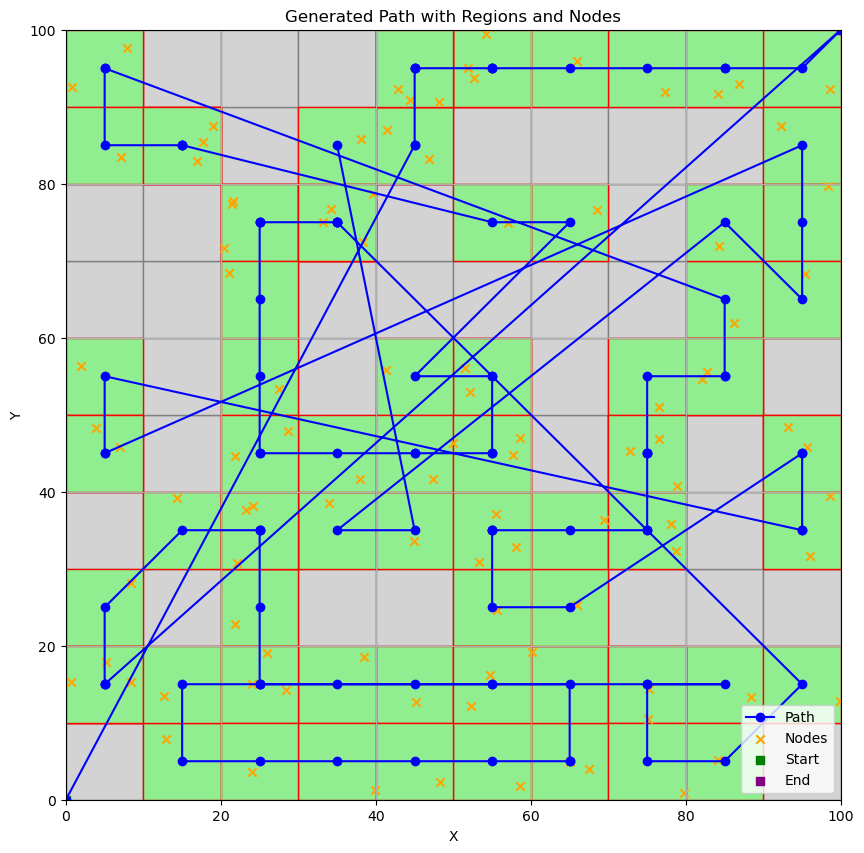

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import distance_matrix

def generate_nodes(a, b, n):
    """在地图内随机生成n个节点"""
    return [(np.random.uniform(0, a), np.random.uniform(0, b)) for _ in range(n)]

def divide_map_into_regions(a, b, d):
    """将地图划分为边长为d的矩形区域"""
    regions = []
    x_splits = int(np.ceil(a / d))
    y_splits = int(np.ceil(b / d))
    for i in range(x_splits):
        for j in range(y_splits):
            x1, y1 = i * d, j * d
            x2, y2 = min(x1 + d, a), min(y1 + d, b)
            region_center = ((x1 + x2) / 2, (y1 + y2) / 2)
            regions.append(((x1, y1, x2, y2), region_center))
    return regions

def find_regions_with_nodes(regions, nodes):
    """找到包含节点的区域并标记"""
    regions_with_nodes = []
    for node in nodes:
        for region, center in regions:
            x1, y1, x2, y2 = region
            if x1 <= node[0] < x2 and y1 <= node[1] < y2:
                regions_with_nodes.append((region, center))
                break
    return regions_with_nodes

def tsp_path_planning(a, b, n, d, nodes):
    """路径规划算法模块化"""
    regions = divide_map_into_regions(a, b, d)
    regions_with_nodes = find_regions_with_nodes(regions, nodes)
    region_centers = [center for _, center in regions_with_nodes]
    
    # Include the start and end points as potential centers
    start = (0, 0)
    end = (a, b)
    region_centers = [start] + region_centers + [end]
    
    # Create adjacency matrix for region centers
    adj_matrix = create_adjacency_matrix(region_centers, d)
    
    # Solve TSP using optimized greedy approach
    path_indices = prioritized_greedy_path_planning(0, region_centers, adj_matrix, d)
    
    # Convert path indices to coordinates
    path_coordinates = [region_centers[i] for i in path_indices]
    
    return path_coordinates, regions, regions_with_nodes, nodes

def create_adjacency_matrix(region_centers, d):
    """创建相邻矩形的邻接矩阵"""
    n = len(region_centers)
    adj_matrix = np.zeros((n, n))
    distances = distance_matrix(region_centers, region_centers)
    for i in range(n):
        for j in range(n):
            if i != j:
                dist = np.linalg.norm(np.array(region_centers[i]) - np.array(region_centers[j]))
                if dist <= d * np.sqrt(2):  # Considering diagonal neighbors
                    adj_matrix[i, j] = dist
    return adj_matrix

def get_neighbors(index, region_centers, d):
    """获取当前矩形中心的邻居"""
    current_center = region_centers[index]
    neighbors = []
    for i, center in enumerate(region_centers):
        if i != index:
            dist = np.linalg.norm(np.array(current_center) - np.array(center))
            if dist <= d * np.sqrt(2):
                neighbors.append((i, dist))
    return neighbors

def prioritized_greedy_path_planning(start, region_centers, adj_matrix, d):
    """优先前往相邻方格的贪心算法"""
    n = len(region_centers)
    path = [start]
    visited = set()
    visited.add(start)
    current_index = start
    
    while len(visited) < n:
        neighbors = get_neighbors(current_index, region_centers, d)
        next_index = None
        min_dist = np.inf
        
        # 优先选择最近的未访问邻居
        for neighbor, dist in neighbors:
            if neighbor not in visited and dist < min_dist:
                min_dist = dist
                next_index = neighbor
        
        if next_index is None:
            # 如果没有未访问的邻居，则扩展搜索范围
            for i in range(n):
                if i not in visited and adj_matrix[current_index][i] < min_dist:
                    min_dist = adj_matrix[current_index][i]
                    next_index = i
        
        if next_index is not None:
            path.append(next_index)
            visited.add(next_index)
            current_index = next_index
        else:
            break
    
    return path

def plot_path(coordinates, regions, regions_with_nodes, nodes, a, b, d):
    """绘制路径、区域、节点"""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # 绘制矩形区域
    for region, _ in regions:
        x1, y1, x2, y2 = region
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='gray', facecolor='lightgray')
        ax.add_patch(rect)
    
    # 标记含有节点的矩形区域
    for region, _ in regions_with_nodes:
        x1, y1, x2, y2 = region
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='red', facecolor='lightgreen')
        ax.add_patch(rect)
    
    # 绘制路径
    x_coords, y_coords = zip(*coordinates)
    ax.plot(x_coords, y_coords, marker='o', color='blue', label="Path")
    
    # 绘制节点
    node_x, node_y = zip(*nodes)
    ax.scatter(node_x, node_y, color='orange', marker='x', label="Nodes")
    
    # 绘制起点和终点
    ax.scatter(0, 0, color='green', marker='s', label="Start")
    ax.scatter(a, b, color='purple', marker='s', label="End")
    
    ax.set_xlim(0, a)
    ax.set_ylim(0, b)
    ax.set_title("Generated Path with Regions and Nodes")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend()
    ax.grid(True)
    plt.show()

# Example usage
a = 100
b = 100
n = 100
d = 10.0

# Step 1: Generate nodes
nodes = generate_nodes(a, b, n)

# Step 2: Path planning
coordinates, regions, regions_with_nodes, nodes = tsp_path_planning(a, b, n, d, nodes)

# Step 3: Plot the path, regions, and nodes
plot_path(coordinates, regions, regions_with_nodes, nodes, a, b, d)
